In [1]:
import transformers

print("Transformers Version:", transformers.__version__)


Transformers Version: 4.26.1


In [2]:
import warnings
from transformers import logging

warnings.filterwarnings('ignore')
logging.set_verbosity_error()


In [3]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [4]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.disable_caching()

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [5]:
categories = set(vispam_datasets['train']['category'] + vispam_datasets['dev']['category'] + vispam_datasets['test']['category'])
category2idx = {p:i for i, p in enumerate(categories)}
num_categories = len(category2idx)
print("Number of categories:", num_categories)


Number of categories: 12


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MetaParamManager():
    
    def __init__(self):
        self.meta_em = {}

    def state_dict(self):
        return self.meta_em

    def register(self, name, param):
        self.meta_em[name] = param
        

class BasicLinear(nn.Module):
    
    def __init__(self, state_size, num_classes):
        super(BasicLinear, self).__init__()
        self.W = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, x):
        out = self.W(x)
        return out
    
    
class CustLinear(nn.Module):
    
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size*num_classes))
            meta_param_manager.register("CustLinear." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        W = torch.cat([getattr(self, name)(idx).view(x.shape[0], self.state_size, self.num_classes) for name, idx in kwargs.items()], dim=1)
        x = x.unsqueeze(dim=1).repeat(1, 1, len(kwargs))
        out = torch.bmm(x, W).squeeze(dim=1)
        return out
    
    
class BasisCustLinear(nn.Module):
    
    def __init__(self, meta_units, meta_dim, key_query_size, state_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustLinear." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            nn.Linear(meta_dim*len(meta_units), key_query_size),  # From MetaData to Query
            nn.Tanh(),
            # Calculate weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            nn.Linear(num_bases, state_size * num_classes),  # Weighted Sum of Bases
        )
        
    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        W = self.P(conc).view(x.shape[0], self.state_size, self.num_classes)
        out = torch.bmm(x.unsqueeze(dim=1), W).squeeze(dim=1)
        return out
    
    
class BasicBias(nn.Module):
    
    def __init__(self, num_classes):
        super(BasicBias, self).__init__()
        self.b = nn.Parameter(torch.zeros((1, num_classes)))

    def forward(self):
        return self.b
    
    
class CustBias(nn.Module):
    
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size))
            meta_param_manager.register("CustBias." + name, getattr(self, name).weight)
            
        self.Y = nn.Linear(state_size*len(meta_units), num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(conc)
        return out
    
    
class BasisCustBias(nn.Module):
    
    def __init__(self, meta_units, meta_dim, state_size, key_query_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustBias." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, state_size),
        )
        
        self.Y = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(self.P(conc))
        return out
    

In [7]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        self.model_name = model_name
        name, model_type = model_name.split('_')
        
        assert name in ['PhoBERT', 'BERT4News']
        assert model_type in ['CustBias', 'CustLinear', 'BasisCustBias', 'BasisCustLinear']
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.freeze_bert = freeze_bert
        self.drop = drop
        
        self.meta_dim = 64
        self.key_query_size = 64
        self.num_bases = 4
        
        self.meta_param_manager = MetaParamManager()
        self.meta_units = [('category_id', num_categories)]
        
        if name == 'PhoBERT':
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        else:
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
                
        self.state_size = 768
        
        # self.drop = nn.Dropout(drop)
        # self.fc = nn.Linear(self.bert.config.hidden_size, self.state_size)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
        # Linear
        if model_type == 'CustLinear':
            self.W = CustLinear(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustLinear':
            self.W = BasisCustLinear(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                state_size=self.state_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.W = BasicLinear(state_size=self.state_size, num_classes=self.num_classes)
            
        # Bias
        if model_type == 'CustBias':
            self.bias = CustBias(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustBias':
            self.bias = BasisCustBias(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                state_size=self.state_size,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.bias = BasicBias(self.num_classes)
        
    def forward(self, input_ids, attention_mask, category_id):
        batch_size, sequence_length = input_ids.shape
        last_hidden_state, output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        
        # output = self.drop(bert_output)
        # output = self.fc(output)
        
        if 'CustLinear' in self.model_name:
            x = self.W(output, category_id)
        else:
            x = self.W(output)

        if 'CustBias' in self.model_name:
            x += self.bias(category_id)
        else:
            x += self.bias()

        return x
    

In [8]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [9]:
import os
import gc
import json
import torch
from torch import nn
import numpy as np
from scipy import interpolate
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    trues = []
    predicts = []

    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, category_id=category_id)

        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]
        
        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        
        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            category_id = data['category_id'].to(device)
            labels = data[label_column].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, category_id=category_id)
            pred = torch.max(outputs, dim=1)[1]
            
            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())
            
            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())
            
    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task):
    torch.cuda.empty_cache()
    gc.collect()
    
    Path(model.model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model.model_name, f"{model.model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_f1 = 0
    best_model_path = os.path.join(model.model_name, f"{model.model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model.model_name, f"{model.model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*50)
        
        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Train F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))
        
        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model.model_name, f"{model.model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history


def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, category_id=category_id)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)
    
    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    if len(history['train_loss']) <= 1:
        return False
    
    colors = plt.get_cmap('tab10').colors

    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    
    
def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()
    

In [10]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")

def encode_mapping(examples):
    text_encoded = tokenizer(examples["clean_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)
    category_ids = [category2idx[category] for category in examples['category']]
    text_encoded.update({"category_id": category_ids})
    
    return text_encoded


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [11]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = vispam_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = vispam_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels)
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights

(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


# BERT4News - Cust Bias

## Task 1

In [14]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News_CustBias", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8469 - Train F1-score: 0.8109 - Train Loss: 0.3937
Valid Accuracy: 0.8911 - Valid F1-score: 0.8551 - Valid Loss: 0.3677
Validation loss decreased (inf --> 0.367746). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9102 - Train F1-score: 0.8869 - Train Loss: 0.2740
Valid Accuracy: 0.8886 - Valid F1-score: 0.8569 - Valid Loss: 0.3756
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9476 - Train F1-score: 0.9330 - Train Loss: 0.1872
Valid Accuracy: 0.8993 - Valid F1-score: 0.8648 - Valid Loss: 0.4438
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9702 - Train F1-score: 0.9618 - Train Loss: 0.1305
Valid Accuracy: 0.8899 - Valid F1-score: 0.8507 - Valid Loss: 0.6237
EarlyStopping counter: 3 out of 3
Early stopping.


In [15]:
save_visualization_history(history, 'BERT4News_CustBias', task=1)
plotting_history(history)


In [16]:
import os
import torch

model_name = "BERT4News_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8880
Precision: 0.8617
Recall: 0.8457
F1-score: 0.8532
Confusion matrix:
 [[2724  187]
 [ 257  795]]
              precision    recall  f1-score   support

           0     0.9138    0.9358    0.9246      2911
           1     0.8096    0.7557    0.7817      1052

    accuracy                         0.8880      3963
   macro avg     0.8617    0.8457    0.8532      3963
weighted avg     0.8861    0.8880    0.8867      3963



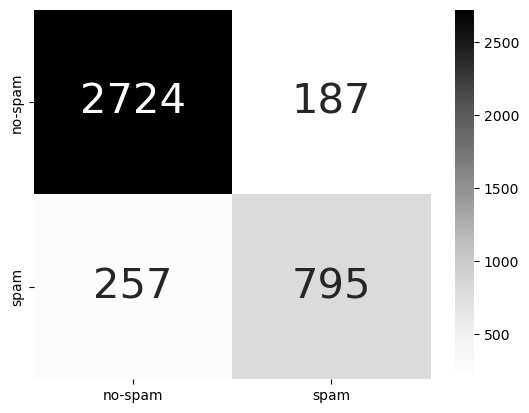

In [17]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [18]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News_CustBias", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7856 - Train F1-score: 0.6262 - Train Loss: 0.7456
Valid Accuracy: 0.8420 - Valid F1-score: 0.6075 - Valid Loss: 0.7288
Validation loss decreased (inf --> 0.728794). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8831 - Train F1-score: 0.7622 - Train Loss: 0.4916
Valid Accuracy: 0.8678 - Valid F1-score: 0.6401 - Valid Loss: 0.8591
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9270 - Train F1-score: 0.8472 - Train Loss: 0.3490
Valid Accuracy: 0.8785 - Valid F1-score: 0.6481 - Valid Loss: 1.1451
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9558 - Train F1-score: 0.8995 - Train Loss: 0.2522
Valid Accuracy: 0.8867 - Valid F1-score: 0.6979 - Valid Loss: 1.4074
EarlyStopping counter: 3 out of 3
Early stopping.


In [19]:
save_visualization_history(history, 'BERT4News_CustBias', task=2)
plotting_history(history)


In [20]:
import os
import torch

model_name = "BERT4News_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8759
Precision: 0.7517
Recall: 0.6917
F1-score: 0.7158
Confusion matrix:
 [[2701    9  137   64]
 [  17   25    2   10]
 [ 137    0  165    7]
 [  93    2   14  580]]
              precision    recall  f1-score   support

           0     0.9162    0.9279    0.9220      2911
           1     0.6944    0.4630    0.5556        54
           2     0.5189    0.5340    0.5263       309
           3     0.8775    0.8418    0.8593       689

    accuracy                         0.8759      3963
   macro avg     0.7517    0.6917    0.7158      3963
weighted avg     0.8755    0.8759    0.8752      3963



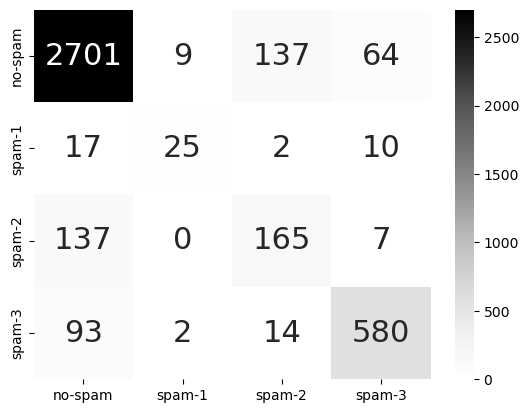

In [21]:
plotting_confusion_matrix(test_cm, task=2)


# BERT4News - Basis Cust Bias

## Task 1

In [22]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News_BasisCustBias", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8491 - Train F1-score: 0.8134 - Train Loss: 0.3826
Valid Accuracy: 0.8874 - Valid F1-score: 0.8488 - Valid Loss: 0.3636
Validation loss decreased (inf --> 0.363648). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9097 - Train F1-score: 0.8859 - Train Loss: 0.2726
Valid Accuracy: 0.8339 - Valid F1-score: 0.8059 - Valid Loss: 0.3725
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9479 - Train F1-score: 0.9337 - Train Loss: 0.1881
Valid Accuracy: 0.8955 - Valid F1-score: 0.8489 - Valid Loss: 0.7162
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9702 - Train F1-score: 0.9617 - Train Loss: 0.1327
Valid Accuracy: 0.8930 - Valid F1-score: 0.8522 - Valid Loss: 0.8000
EarlyStopping counter: 3 out of 3
Early stopping.


In [23]:
save_visualization_history(history, 'BERT4News_BasisCustBias', task=1)
plotting_history(history)


In [24]:
import os
import torch

model_name = "BERT4News_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8857
Precision: 0.8653
Recall: 0.8327
F1-score: 0.8468
Confusion matrix:
 [[2753  158]
 [ 295  757]]
              precision    recall  f1-score   support

           0     0.9032    0.9457    0.9240      2911
           1     0.8273    0.7196    0.7697      1052

    accuracy                         0.8857      3963
   macro avg     0.8653    0.8327    0.8468      3963
weighted avg     0.8831    0.8857    0.8830      3963



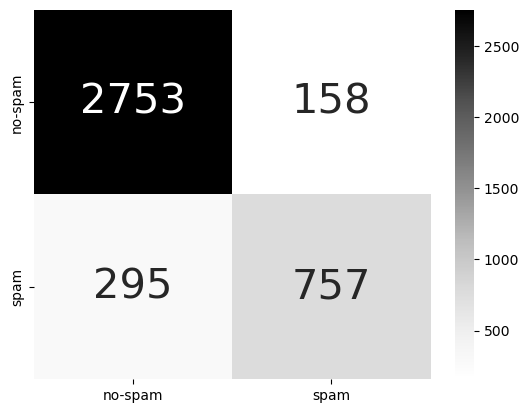

In [25]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [26]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News_BasisCustBias", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7937 - Train F1-score: 0.6434 - Train Loss: 0.7273
Valid Accuracy: 0.8395 - Valid F1-score: 0.5949 - Valid Loss: 0.9130
Validation loss decreased (inf --> 0.913012). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8834 - Train F1-score: 0.7605 - Train Loss: 0.5063
Valid Accuracy: 0.8704 - Valid F1-score: 0.6639 - Valid Loss: 0.8161
Validation loss decreased (0.913012 --> 0.816123). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9267 - Train F1-score: 0.8456 - Train Loss: 0.3684
Valid Accuracy: 0.8641 - Valid F1-score: 0.6469 - Valid Loss: 0.9360
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9530 - Train F1-score: 0.8977 - Train Loss: 0.2471
Valid Accuracy: 0.8792 - Valid F1-score: 0.6638 - Valid Loss: 1.3293
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9712 - Train F1-score: 0.9311 - Train Loss: 0.1731
Valid Accuracy: 0.8874 - Valid F1-score: 0.6588 - Valid Loss: 1.8713
EarlyStopping counter: 3 out of 3
Early stopping.


In [27]:
save_visualization_history(history, 'BERT4News_BasisCustBias', task=2)
plotting_history(history)


In [28]:
import os
import torch

model_name = "BERT4News_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8786
Precision: 0.7634
Recall: 0.6650
F1-score: 0.7067
Confusion matrix:
 [[2777    9   86   39]
 [  21   26    2    5]
 [ 174    0  134    1]
 [ 118    3   23  545]]
              precision    recall  f1-score   support

           0     0.8987    0.9540    0.9255      2911
           1     0.6842    0.4815    0.5652        54
           2     0.5469    0.4337    0.4838       309
           3     0.9237    0.7910    0.8522       689

    accuracy                         0.8786      3963
   macro avg     0.7634    0.6650    0.7067      3963
weighted avg     0.8727    0.8786    0.8734      3963



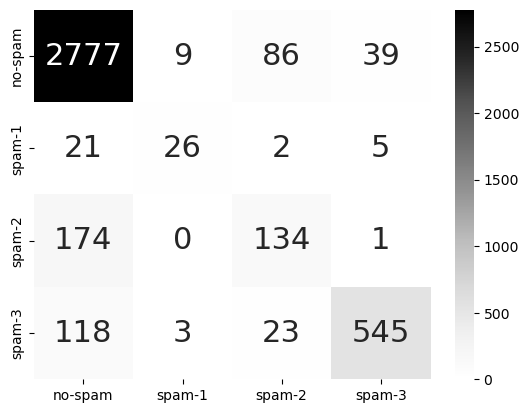

In [29]:
plotting_confusion_matrix(test_cm, task=2)


# BERT4News - Cust Linear

## Task 1

In [30]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News_CustLinear", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7693 - Train F1-score: 0.7251 - Train Loss: 1.2152
Valid Accuracy: 0.8257 - Valid F1-score: 0.7822 - Valid Loss: 0.8973
Validation loss decreased (inf --> 0.897347). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8552 - Train F1-score: 0.8206 - Train Loss: 0.5531
Valid Accuracy: 0.8735 - Valid F1-score: 0.8270 - Valid Loss: 0.7430
Validation loss decreased (0.897347 --> 0.742996). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9088 - Train F1-score: 0.8849 - Train Loss: 0.4001
Valid Accuracy: 0.8553 - Valid F1-score: 0.8213 - Valid Loss: 0.6738
Validation loss decreased (0.742996 --> 0.673765). Saving model ...
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9440 - Train F1-score: 0.9286 - Train Loss: 0.2755
Valid Accuracy: 0.8899 - Valid F1-score: 0.8537 - Valid Loss: 1.0240
EarlyStopping counter: 1 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9705 - Train F1-score: 0.9622 - Train Loss: 0.1641
Valid Accuracy: 0.8836 - Valid F1-score: 0.8432 - Valid Loss: 1.2685
EarlyStopping counter: 2 out of 3
Epoch 6/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9831 - Train F1-score: 0.9782 - Train Loss: 0.1013
Valid Accuracy: 0.8924 - Valid F1-score: 0.8523 - Valid Loss: 1.6683
EarlyStopping counter: 3 out of 3
Early stopping.


In [31]:
save_visualization_history(history, 'BERT4News_CustLinear', task=1)
plotting_history(history)


In [32]:
import os
import torch

model_name = "BERT4News_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8857
Precision: 0.8655
Recall: 0.8323
F1-score: 0.8467
Confusion matrix:
 [[2754  157]
 [ 296  756]]
              precision    recall  f1-score   support

           0     0.9030    0.9461    0.9240      2911
           1     0.8280    0.7186    0.7695      1052

    accuracy                         0.8857      3963
   macro avg     0.8655    0.8323    0.8467      3963
weighted avg     0.8831    0.8857    0.8830      3963



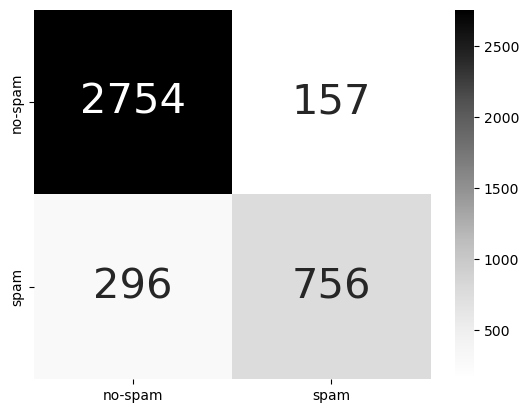

In [33]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [34]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News_CustLinear", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.6775 - Train F1-score: 0.4812 - Train Loss: 2.7442
Valid Accuracy: 0.6073 - Valid F1-score: 0.4665 - Valid Loss: 1.5024
Validation loss decreased (inf --> 1.502437). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7967 - Train F1-score: 0.6258 - Train Loss: 1.1902
Valid Accuracy: 0.8118 - Valid F1-score: 0.5714 - Valid Loss: 1.5907
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8657 - Train F1-score: 0.7361 - Train Loss: 0.8358
Valid Accuracy: 0.8603 - Valid F1-score: 0.6542 - Valid Loss: 1.6056
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9147 - Train F1-score: 0.8264 - Train Loss: 0.5766
Valid Accuracy: 0.8634 - Valid F1-score: 0.6276 - Valid Loss: 2.3274
EarlyStopping counter: 3 out of 3
Early stopping.


In [35]:
save_visualization_history(history, 'BERT4News_CustLinear', task=2)
plotting_history(history)


In [36]:
import os
import torch

model_name = "BERT4News_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8607
Precision: 0.6718
Recall: 0.6506
F1-score: 0.6604
Confusion matrix:
 [[2701   18  140   52]
 [  18   23    4    9]
 [ 162    1  141    5]
 [ 109   11   23  546]]
              precision    recall  f1-score   support

           0     0.9033    0.9279    0.9154      2911
           1     0.4340    0.4259    0.4299        54
           2     0.4578    0.4563    0.4571       309
           3     0.8922    0.7925    0.8394       689

    accuracy                         0.8607      3963
   macro avg     0.6718    0.6506    0.6604      3963
weighted avg     0.8603    0.8607    0.8599      3963



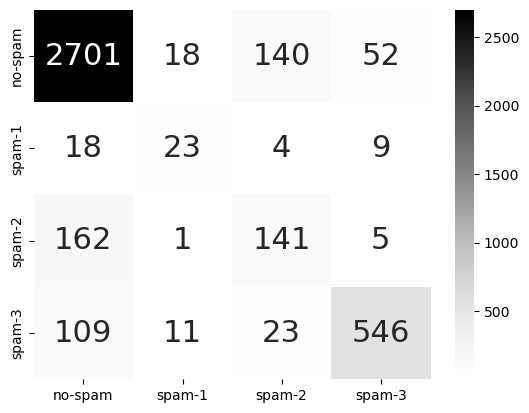

In [37]:
plotting_confusion_matrix(test_cm, task=2)


# BERT4News - Basis Cust Linear

## Task 1

In [38]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News_BasisCustLinear", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8080 - Train F1-score: 0.7697 - Train Loss: 0.5227
Valid Accuracy: 0.8855 - Valid F1-score: 0.8418 - Valid Loss: 0.4674
Validation loss decreased (inf --> 0.467400). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8895 - Train F1-score: 0.8622 - Train Loss: 0.3161
Valid Accuracy: 0.8603 - Valid F1-score: 0.8302 - Valid Loss: 0.3364
Validation loss decreased (0.467400 --> 0.336448). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9355 - Train F1-score: 0.9182 - Train Loss: 0.2284
Valid Accuracy: 0.8842 - Valid F1-score: 0.8529 - Valid Loss: 0.4595
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9652 - Train F1-score: 0.9553 - Train Loss: 0.1596
Valid Accuracy: 0.8874 - Valid F1-score: 0.8475 - Valid Loss: 0.9448
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9804 - Train F1-score: 0.9748 - Train Loss: 0.0987
Valid Accuracy: 0.8829 - Valid F1-score: 0.8395 - Valid Loss: 1.1421
EarlyStopping counter: 3 out of 3
Early stopping.


In [39]:
save_visualization_history(history, 'BERT4News_BasisCustLinear', task=1)
plotting_history(history)


In [40]:
import os
import torch

model_name = "BERT4News_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8842
Precision: 0.8602
Recall: 0.8350
F1-score: 0.8463
Confusion matrix:
 [[2736  175]
 [ 284  768]]
              precision    recall  f1-score   support

           0     0.9060    0.9399    0.9226      2911
           1     0.8144    0.7300    0.7699      1052

    accuracy                         0.8842      3963
   macro avg     0.8602    0.8350    0.8463      3963
weighted avg     0.8817    0.8842    0.8821      3963



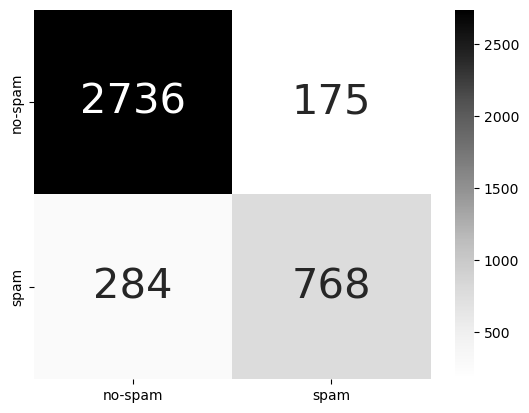

In [41]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [42]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News_BasisCustLinear", task=2).to(device)
print(model)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


ViSpam_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(62000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7327 - Train F1-score: 0.5550 - Train Loss: 1.0053
Valid Accuracy: 0.8326 - Valid F1-score: 0.6637 - Valid Loss: 0.8985
Validation loss decreased (inf --> 0.898549). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8492 - Train F1-score: 0.7147 - Train Loss: 0.6289
Valid Accuracy: 0.8565 - Valid F1-score: 0.6727 - Valid Loss: 0.8462
Validation loss decreased (0.898549 --> 0.846190). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9025 - Train F1-score: 0.8110 - Train Loss: 0.4102
Valid Accuracy: 0.8295 - Valid F1-score: 0.5886 - Valid Loss: 1.1569
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9474 - Train F1-score: 0.8911 - Train Loss: 0.2957
Valid Accuracy: 0.8597 - Valid F1-score: 0.6383 - Valid Loss: 1.4757
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9718 - Train F1-score: 0.9351 - Train Loss: 0.1899
Valid Accuracy: 0.8836 - Valid F1-score: 0.6620 - Valid Loss: 2.4613
EarlyStopping counter: 3 out of 3
Early stopping.


In [43]:
save_visualization_history(history, 'BERT4News_BasisCustLinear', task=2)
plotting_history(history)


In [44]:
import os
import torch

model_name = "BERT4News_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8776
Precision: 0.7361
Recall: 0.6827
F1-score: 0.7061
Confusion matrix:
 [[2724   11   94   82]
 [  16   26    1   11]
 [ 153    0  144   12]
 [  83    5   17  584]]
              precision    recall  f1-score   support

           0     0.9153    0.9358    0.9254      2911
           1     0.6190    0.4815    0.5417        54
           2     0.5625    0.4660    0.5097       309
           3     0.8476    0.8476    0.8476       689

    accuracy                         0.8776      3963
   macro avg     0.7361    0.6827    0.7061      3963
weighted avg     0.8720    0.8776    0.8743      3963



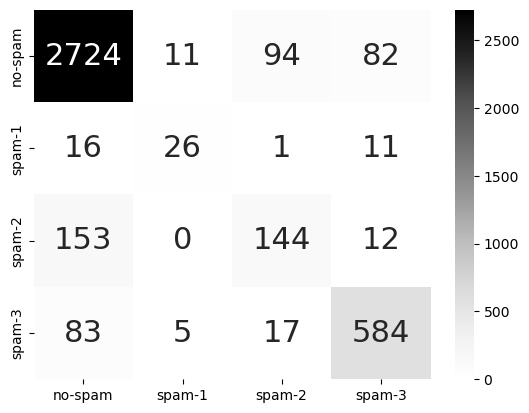

In [45]:
plotting_confusion_matrix(test_cm, task=2)
